In [24]:
from elasticsearch import Elasticsearch

In [25]:
es = Elasticsearch(
    "http://localhost:9200",
#     basic_auth=("elastic","LQym+efHnUy9DbT-jtD2"),
#     ca_certs="/Users/abidsaudagar/Personal/yt1_semantic_search/elasticsearch-8.9.1/config/certs/http_ca.crt"
)
client = es.info()
print(client)

ConnectionError: Connection error caused by: ConnectionError(Connection error caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x00000155EBE684F0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it))

## Prepare the data

In [13]:
import pandas as pd

df = pd.read_csv("output_try1st(1).csv",encoding="latin-1")
df

,Type,Session,Content
0,Table,Title 0. Begin,<table><thead><tr><th>Revision</th><th>Date</t...
1,Table,Title 0. Begin,"<table><tbody><tr><td colspan=""2"">Acronyms</td..."
2,Table,Title 0. Begin,<table><tbody></tbody></table>
3,Text,Title 0. Begin,Title: Arrive Technologies Inc.\nTitle: Guidel...
4,Text,Title: 1. Abstract,The purpose of this document is to define one ...
5,Text,Title: 2. Acronyms,Empty section.\n
6,Text,Title: 3. Related Documents,Empty section.\n
7,Text,Title: 4. Requirements,Empty section.\n
8,Text,Title: 5. Revision Changes,NaN
9,Table,Title: 5. Revision Changes,<table><thead><tr><th>evision</th><th></th><th...


In [14]:
df.isna().value_counts()

Type   Session  Content
False  False    False      59
                True        1
Name: count, dtype: int64

In [15]:
df.fillna("None", inplace=True)
df.describe()

,Type,Session,Content
count,60,60,60
unique,3,41,57
top,Text,Comments,Empty section.\n
freq,29,5,3


In [16]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain.embeddings import OllamaEmbeddings
from langchain.chat_models import ChatOllama
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

template = """
You are an assistant tasked with summarizing tables as html and text.
Give a concise summary of the table or text. 

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {context}

"""

prompt = ChatPromptTemplate.from_template(template)

# Define RAG pipeline with metadata-aware retrieval

prompting = ChatOllama(model="llama3.2:1b")
text_summarizes = []
for i in range(len(df)):
  try:
    if df.loc[i, 'Type'] == "Code":
        df.loc[i, 'Summary'] = df.loc[i, 'Content']  # Fix here
        continue
    
    text_summarize = f"This is {df['Type'].iloc[i]} of Session {df['Session'].iloc[i]} \n"
    rag_chain = (
        RunnablePassthrough()  
        | prompt
        | prompting
        | StrOutputParser()
    )
    text_summarize += rag_chain.invoke({"context": df.loc[i, 'Content']})  # This line is correct
    df.loc[i, "Summary"] = text_summarize       
  except Exception as e:
    print(f"error in {i}: {e}")

df    

,Type,Session,Content,Summary
0,Table,Title 0. Begin,<table><thead><tr><th>Revision</th><th>Date</t...,This is Table of Session Title 0. Begin \nRevi...
1,Table,Title 0. Begin,"<table><tbody><tr><td colspan=""2"">Acronyms</td...",This is Table of Session Title 0. Begin \nAcro...
2,Table,Title 0. Begin,<table><tbody></tbody></table>,This is Table of Session Title 0. Begin \n<det...
3,Text,Title 0. Begin,Title: Arrive Technologies Inc.\nTitle: Guidel...,This is Text of Session Title 0. Begin \nContr...
4,Text,Title: 1. Abstract,The purpose of this document is to define one ...,This is Text of Session Title: 1. Abstract \nT...
5,Text,Title: 2. Acronyms,Empty section.\n,This is Text of Session Title: 2. Acronyms \nN...
6,Text,Title: 3. Related Documents,Empty section.\n,This is Text of Session Title: 3. Related Docu...
7,Text,Title: 4. Requirements,Empty section.\n,This is Text of Session Title: 4. Requirements...
8,Text,Title: 5. Revision Changes,None,This is Text of Session Title: 5. Revision Cha...
9,Table,Title: 5. Revision Changes,<table><thead><tr><th>evision</th><th></th><th...,This is Table of Session Title: 5. Revision Ch...


## Convert the relevant field to Vector using BERT model

In [17]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

In [27]:
df["SummaryVector"] = df["Summary"].apply(lambda x: model.encode(x))

In [19]:
df.head()

,Type,Session,Content,Summary,SummaryVector
0,Table,Title 0. Begin,<table><thead><tr><th>Revision</th><th>Date</t...,This is Table of Session Title 0. Begin \nRevi...,"[0.010518189, -0.005657123, -0.025594493, -0.0..."
1,Table,Title 0. Begin,"<table><tbody><tr><td colspan=""2"">Acronyms</td...",This is Table of Session Title 0. Begin \nAcro...,"[0.0045497525, -0.056150638, -0.04241401, -0.0..."
2,Table,Title 0. Begin,<table><tbody></tbody></table>,This is Table of Session Title 0. Begin \n<det...,"[-0.023008423, -0.080534995, 0.00312593, 0.039..."
3,Text,Title 0. Begin,Title: Arrive Technologies Inc.\nTitle: Guidel...,This is Text of Session Title 0. Begin \nContr...,"[-0.022166427, -0.03358669, -0.014336729, 0.03..."
4,Text,Title: 1. Abstract,The purpose of this document is to define one ...,This is Text of Session Title: 1. Abstract \nT...,"[0.018972438, -0.0004060522, -0.024327658, 0.0..."


In [20]:
es.ping()

True

## Create new index in ElasticSearch!

In [28]:
from indexMapping import indexMapping
index_name = 'lang1'
if es.indices.exists(index=index_name):
  es.indices.delete(index=index_name)
  print(f"Index '{index_name}' deleted.")
es.indices.create(index=index_name, mappings=indexMapping)

Index 'lang1' deleted.


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'lang1'})

## Ingest the data into index

In [29]:
record_list = df.to_dict("records")

In [30]:
for record in record_list:
    try:
        es.index(index="lang1", document=record)
    except Exception as e:
        print(e)

In [31]:
es.count(index="lang1")

ObjectApiResponse({'count': 60, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})

## Search the data

In [ ]:
input_keyword = "rule for constant name"
vector_of_input_keyword = model.encode(input_keyword)

max_candi = es.count(index="lang1")["count"]

query = {
    "field" : "SummaryVector",
    "query_vector" : vector_of_input_keyword,
    "k" : 5,
    "num_candidates" : max_candi , 
}

res = es.knn_search(index="lang1", knn=query , source=["Content","Summary"])
res["hits"]["hits"]

C:\Users\MSI\AppData\Local\Temp\ipykernel_8380\2283771946.py:13: GeneralAvailabilityWarning: This API is in technical preview and may be changed or removed in a future release. Elastic will work to fix any issues, but features in technical preview are not subject to the support SLA of official GA features.
  res = es.knn_search(index="lang1", knn=query , source=["Content","Summary"])
C:\Users\MSI\AppData\Local\Temp\ipykernel_8380\2283771946.py:13: ElasticsearchWarning: The kNN search API has been replaced by the `knn` option in the search API.
  res = es.knn_search(index="lang1", knn=query , source=["Content","Summary"])


[{'_index': 'lang1',
  '_id': 'zg9QJpUBNVjsu2bnmddm',
  '_score': 0.4990725,
  '_source': {'Content': '= When creating names, remember that the code will be written once or twice, but read many times. Make names meaningful and readable, and avoid obscure abbreviations. In general, the following guidelines must be followed.\n= In general, names should be lowercase and be composed of words, abbreviations, and acronyms combined together with underscores (as rarely as possible). The composed word should form a close description of the object named. The name should be long enough for the reader to be able to determine what the object is for. Besides, the name should be shorter than 10 characters for good synthesis procedure.\n= Minimize the use of abbreviations.\n= Use abbreviations consistently.\nTitle: For example:\ninput prs; // it means processor write strobe input [4:0] framecnt; // it means frame count, do not use frame_count // because frame_count is so long. input t_run; // it means

<p>INFEENCE</p>

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain.embeddings import OllamaEmbeddings
from langchain.chat_models import ChatOllama
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

template = """
You are an expert in  IC design.  Your answer can based on code or just theory
Answer the question based **only** on the following context:
{context}
Question: {question}
"""  

llm = ChatOllama(
    model = "deepseek-r1:1.5b",
    temperature = 0,
)
prompt = ChatPromptTemplate.from_template(template)

# # i = 0
try:
  context = '\n'.join(item['_source']['Content'] for item in res["hits"]["hits"])
  # text_summarize = f"This is {df['Type'].iloc[i]} of Session {df['Session'].iloc[i]} \n"
  rag_chain = (
  RunnablePassthrough()  
  | prompt
  | prompting
  | StrOutputParser()
)
  output = rag_chain.invoke({"context": context, "question":"rule for constant name"})
  print(output)
  # text_summarize += rag_chain.invoke({"context": df['Content'].iloc[i]})   
  # df.loc[i, "Summary"] = text_summarize       
  # print("Text: ", df['Content'].iloc[i])
  # print("text Summary: ", text_summarize)
  # print(f"Summarize {i} success")
except Exception as e:
  print(f"error in {i}: {e}")

Based on the guidelines, here are some rules for naming constants in Verilog:

*   **Length and Readability**: The name should be long enough for the reader to understand its purpose. However, it shouldn't be too long (less than 10 characters) to improve synthesis efficiency.
*   **Readability by Type**: Constant names should describe their type, not just a single word. For example:
    *   `w1` or `a0` are better than `WR_1_01` and `AC_001`.
*   **No Abbreviations**: Avoid using abbreviations for constant names unless they have an underscore suffix (e.g., `w`, `a`, `b`, etc.).
*   **No Variable Names**: Since constants must be read-only, use the underscore suffix to differentiate them from variable names.
*   **Naming Conventions**:
    *   `_PRG` is a common and readable naming convention for program counter values.
    *   `_RST` or `_ENRDY_1_0` might not be as intuitive without context.


In [1]:
from langchain.chat_models import ChatOllama
from pydantic import BaseModel, Field

llm = ChatOllama(model="llama3.2:1b")

C:\Users\MSI\AppData\Local\Temp\ipykernel_6720\2172879952.py:4: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="llama3.2:1b")


In [ ]:
user_id = 

In [ ]:
from typing_extensions import Literal, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END

# Schema for structured output to use as routing logic
class Route(BaseModel):
  step: Literal["tools", "rag"] = Field(
      None, description="The next step in the routing process"
  )
router = llm.with_structured_output(Route)

class State(TypedDict):
  input: str
  decision: str
  output: str
  
def call_route(state: State):
  if state["decision"] == "text":
    return "rag_text"
  elif state["decision"] == "image":
    return "rag_image"
  elif state["decision"] == ""

def rag_text(state: State):
  return {"output":}



def router(state: State):
  




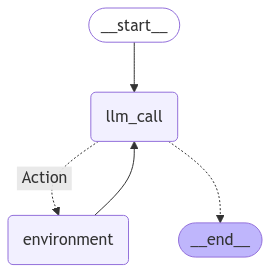

================================ Human Message =================================

Add 3 ; 4 and subtract 7 ; 2
================================== Ai Message ==================================

To solve this problem, I'll follow the order of operations (PEMDAS):

1. Add 3 and 4: 3 + 4 = 7
2. Subtract 7 from the result: 7 - 7 = 0

So the final answer is 0.


In [ ]:
from langchain_core.tools import tool
from langchain.chat_models import ChatOpenAI, ChatOllama
from langgraph.graph import StateGraph, START, END
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = ChatOllama(
    model = "llama3.2:1b",
    temperature=0,
    tools = [divide]
)


from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 ; 4 and subtract 7 ;")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

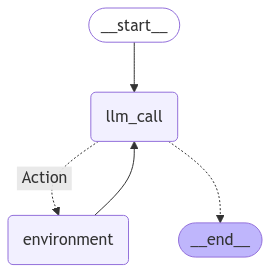

================================ Human Message =================================

Add 3 and 4 then subtract 7 and 2
================================== Ai Message ==================================

To solve this problem, I'll follow the order of operations (PEMDAS):

1. Add 3 and 4: 3 + 4 = 7
2. Subtract 7 from the result: 7 - 7 = 0
3. Subtract 2 from the result: 0 - 2 = -2

The final answer is -2.


In [37]:


from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4 then subtract 7 and 2")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [ ]:
from typing_extensions import Literal, TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_openai import ChatOpenAI

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        description="The next step in the routing process"
    )

llm_no_deep = ChatOpenAI(api_key="ollama", model="llama3.2:1b",  temperature=0, base_url="http://localhost:11434/v1")
structured_llm = llm_no_deep.with_structured_output(Route)

llm = ChatOllama(model="deepseek-r1:1.5b", temperature  = 0)


# State
class State(TypedDict):
    input: str
    decision: Literal["poem", "story", "joke"]
    output: str



# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""
    
    # Run the augmented LLM with structured output to serve as routing logic
    prompt = PromptTemplate(
    input_variables=["input"],
    template="""
    You must categorize the user's request as either 'code', 'content', or 'image'.
    Only return one of these three words exactly, nothing else.

    User request: {input}
    Response: """,
)
    chain = prompt | structured_llm
    decision = chain.invoke({"input": state["input"]})

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
# display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a poem about cats"})
print(state["output"])


Whiskered felines, eyes so bright,
Purrs in the morning, purrs at night.
Their soft fur, a gentle touch,
Inviting snuggles, and a loving clutch.

With claws that scratch, and ears so fine,
They prowl through shadows, with stealthy design.
Their little noses, twitching with glee,
As they explore, wild and carefree.

In sunbeams bright, they bask and play,
Chasing dreams, in a lazy day.
Their playful pounces, bring joy to all,
A symbol of love, that stands tall.

At night, when darkness falls,
They curl up tight, with a gentle call.
Their soft purrs, a lullaby sweet,
As they dream of mice, and secrets to keep.

Cats, oh cats, with your mystery and charm,
You rule our hearts, with your feline form.
A symbol of independence, and love so true,
Forever in our lives, a part of me and you.


In [ ]:
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_openai import ChatOpenAI
# Schema for structured response
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        description="The next step in the routing process"
    )


# # Prompt template
# prompt = PromptTemplate(
#     input_variables=["input"],
#     template="""
#     You must categorize the user's request as either 'code', 'content', or 'image'.
#     Only return one of these three words exactly, nothing else.

#     User request: {input}
#     Response: """,
# )

# Chain
llm = ChatOpenAI(api_key="ollama", model="llama3.2:1b",  temperature=0, base_url="http://localhost:11434/v1")
structured_llm = llm.with_structured_output(Route)
# chain = prompt | structured_llm

# alex = chain.invoke({"input": "Write me a code for print hello world in C"})
# alex

In [6]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# Schema for structured output to use as routing logic
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.chains import LLMChain  # Import LLMChain
from langchain.prompts import PromptTemplate #Import PromptTemplate
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.output_parsers import StrOutputParser
from langchain.chat_models import ChatOpenAI, ChatOllama
import re

llm = ChatOllama(model="deepseek-r1:1.5b", temperature=0)

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["code", "content", "image"] = Field(
        None, description="The next step in the routing process"
    )


# Instead of directly using with_structured_output, create an LLMChain with a custom prompt
# that guides the LLM to output the desired structure.
prompt_template = PromptTemplate(
    input_variables=["input"],
    template="""Route the input to code, content, or images based on the user's request.
    User request: {messages}
    Respond with one or many of the following words: code, content, image""",
)
router_chain = LLMChain(llm=llm, prompt=prompt_template, output_parser=StrOutputParser())

# State
class State(TypedDict):
    messages: str
    decision: str
    output: str

# Nodes
def llm_call_1(state: State):
    """You are a chat assistant that helps users with coding problems.
      You must provide code snippets from the document stored in the database.
      If a user requests code related to a specific subject, search for relevant keywords in their request to find code.
      Give the code and summarize the code explanation in three sentences or fewer."""

    result = llm.invoke(state["messages"])
    print(result)
    return {"output": result.content}


def llm_call_2(state: State):
    """You are a chat assistant that provides textual content and tables (excluding code).
    You must retrieve content from the document stored in the database.
    If a user requests content on a specific subject, search for relevant keywords in their request to find content."""

    result = llm.invoke(state["messages"])
    return {"output": result.content}


def llm_call_3(state: State):
    """You are a chat assistant that provides images from the document stored in the database.
    If a user requests an image related to a specific subject, search for relevant keywords in their request.
    Respond with the image and indicate its section location in the document. Do not provide a detailed explanation."""

    result = llm.invoke(state["messages"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router_chain.run(state["messages"])  # Use router_chain instead of router.invoke
    print(f"Router decision: {decision}")
    print("---------------------------------------")
    match = re.findall(r'\b(code|content|image)\b', decision.lower())
    out_decision = match[-1]
    return {"decision": out_decision}  # Access the decision directly

    # return {"decision": decision}  # Access the decision directly
# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "code":
        return "llm_call_1"
    elif state["decision"] == "content":
        return "llm_call_2"
    elif state["decision"] == "image":  # Changed "images" to "image" for consistency with the prompt
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
# router_builder.add_node("chatbox", chatbox)
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
# display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke


In [7]:
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import JsonOutputParser
parser = JsonOutputParser()
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2? .")]
router = router_workflow | parser
messages = router.invoke({"messages": messages})
print(messages)

Router decision: <think>
Okay, so I need to figure out how to route this user's input. The user provided a message where they want me to "Hello, what is 2 multiplied by 2?" and then specify that it should be answered as "4." They also mentioned additional kwargs and response metadata.

First, I'll look at the parameters given: the content is 'Hello, what is 2 multiplied by 2?', there are no additional kwargs, so I don't need to worry about any other arguments. The response metadata includes a value which is 4, indicating that this should be the output.

I remember that in some AI platforms or coding frameworks, you can route requests using specific keywords like 'content', 'text', 'message', etc. Since the user wants the content of the message to be answered with 4, I think they're asking for a text response.

So, I'll use the 'text' keyword to specify that this is a text request and should return the answer in the same format. That way, when the AI processes it, it will output "4" as 

ValidationError: 1 validation error for Generation
text
  Input should be a valid string [type=string_type, input_value={'messages': [HumanMessag...\n\\[\n\\boxed{4}\n\\]"}, input_type=AddableValuesDict]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type